# Image JEPA Training on CIFAR-10

This notebook demonstrates training an Image JEPA (Joint Embedding Predictive Architecture) model on CIFAR-10 using the eb_jepa framework.

## Hardware Requirements

- This notebook is designed to run on Google Colab with a GPU runtime
- Recommended: GPU with at least 12GB VRAM (e.g., Tesla T4, P100)
- Training time: ~1-2 hours depending on GPU

## Features

- Self-supervised representation learning using VICReg or BCS loss
- Optimized configuration for Colab environment
- Optional Weights & Biases logging integration


In [1]:
# Check if we're running on GPU
!nvidia-smi

Thu Feb 19 12:01:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             51W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Install required packages
!pip install fire omegaconf wandb tqdm

In [3]:
# Clone the repository
!git clone https://github.com/facebookresearch/eb_jepa.git
%cd eb_jepa
!pip install -e .

fatal: destination path 'eb_jepa' already exists and is not an empty directory.
/content/eb_jepa
Obtaining file:///content/eb_jepa
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for eb_jepa (pyproject.toml) ... done
  Created wheel for eb_jepa: filename=eb_jepa-0.1.1-0.editable-py3-none-any.whl size=7314 sha256=c635f6830ba1e6a24330b9ea62c0fd928c1fc15115fb169cc82b0017ba80e9f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-terx552u/wheels/3c/e4/35/e6d54e9b0f0fb0dc97c64fb61e8cc093f794d2ad1c1297efa1
Successfully built eb_jepa
  Attempting uninstall: eb_jepa
    Found existing installation: eb_jepa 0.1.1
    Uninstalling eb_jepa-0.1.1:
      Successfully uninstalled eb_jepa-0.1.1


In [10]:
# Set environment variables for datasets and checkpoints
%env EBJEPA_DSETS=/content/eb_jepa/eb_jepa/datasets
# %env EBJEPA_CKPTS=/content/eb_jepa/checkpoints

env: EBJEPA_DSETS=/content/eb_jepa/eb_jepa/datasets


In [11]:
# Create a modified config for Colab
%%writefile examples/image_jepa/cfgs/colab_config.yaml
meta:
  seed: 42
  device: auto

data:
  dataset: cifar10
  batch_size: 128  # Reduced batch size for Colab
  num_workers: 2   # Reduced workers for Colab

model:
  type: resnet
  use_projector: true
  proj_hidden_dim: 1024  # Reduced dimension for Colab
  proj_output_dim: 1024  # Reduced dimension for Colab

loss:
  type: vicreg
  std_coeff: 1.0
  cov_coeff: 80.0

optim:
  epochs: 50       # Reduced epochs for demonstration
  lr: 0.3
  weight_decay: 1.0e-4
  warmup_epochs: 5
  warmup_start_lr: 3.0e-5
  min_lr: 0.0

logging:
  log_wandb: false  # Disable wandb by default
  log_every: 1
  save_every: 10
  tqdm_silent: false

training:
  use_amp: true
  dtype: float16

Overwriting examples/image_jepa/cfgs/colab_config.yaml


In [12]:
# Optional: Configure W&B logging
import wandb
# wandb.login()  # Uncomment to use W&B logging

In [13]:
# Run training
!python -m examples.image_jepa.main --fname examples/image_jepa/cfgs/colab_config.yaml

[INFO    ][2026-02-19 12:59:33][eb_jepa.training_utils][load_config              ] Loaded config from examples/image_jepa/cfgs/colab_config.yaml
[INFO    ][2026-02-19 12:59:33][eb_jepa.training_utils][setup_device             ] Using device: cuda
[INFO    ][2026-02-19 12:59:33][eb_jepa.training_utils][setup_seed               ] Random seed set to 42
[INFO    ][2026-02-19 12:59:33][eb_jepa.training_utils][setup_wandb              ] W&B logging disabled
[INFO    ][2026-02-19 12:59:33][__main__            ][run                      ] Loading CIFAR-10 dataset...
[INFO    ][2026-02-19 12:59:33][__main__            ][run                      ] Using data directory: /content/eb_jepa/eb_jepa/datasets
100% 170M/170M [00:13<00:00, 12.6MB/s]
[INFO    ][2026-02-19 12:59:52][eb_jepa.training_utils][log_data_info            ] 📦 Data: CIFAR-10 | 390 batches x 128 samples | train=50,000 | val=10,000
[INFO    ][2026-02-19 12:59:52][__main__            ][run                      ] Initializing model...


In [21]:
# Load and visualize results
import torch
import matplotlib.pyplot as plt
from pathlib import Path

def plot_training_progress(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    print(f"Epoch: {checkpoint['epoch']}")
    print(f"Linear Probe Validation Accuracy: {checkpoint.get('linear_val_acc', 'N/A')}%")

    # Add more visualization as needed

# Find the latest checkpoint
latest_checkpoint = Path('/content/eb_jepa/checkpoints/image_jepa/dev_2026-02-19_12-59/resnet_vicreg_proj_bs128_ep50_ph1024_po1024_std1.0_cov80.0_seed42/latest.pth.tar')
if latest_checkpoint.exists():
    plot_training_progress(latest_checkpoint)
else:
    print("No checkpoint found")

Epoch: 49
Linear Probe Validation Accuracy: 81.39%


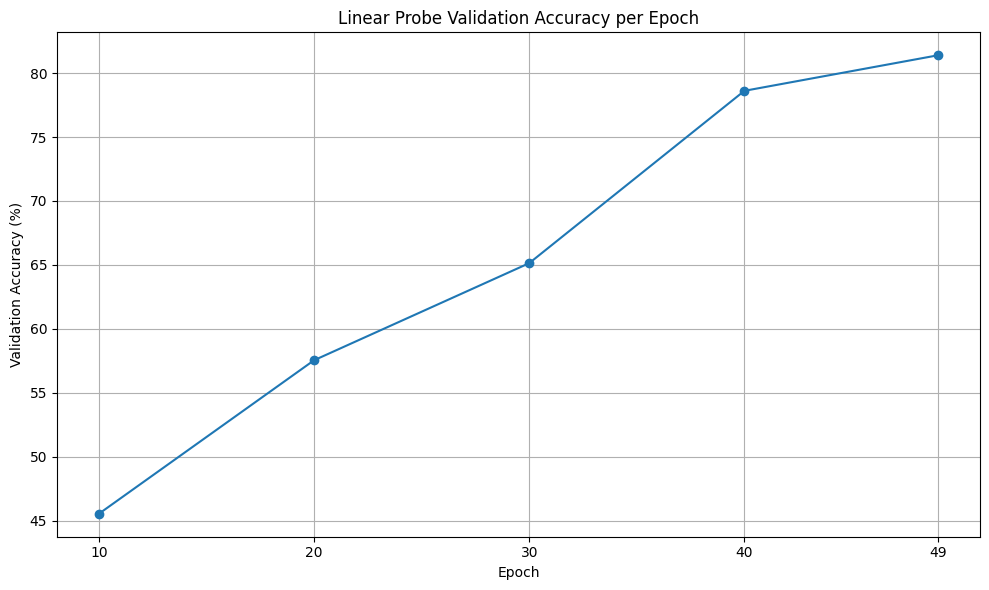

In [22]:
# Plot accuracy at each checkpoint
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import re

checkpoint_dir = Path('/content/eb_jepa/checkpoints/image_jepa/dev_2026-02-19_12-59/resnet_vicreg_proj_bs128_ep50_ph1024_po1024_std1.0_cov80.0_seed42')

epochs = []
accuracies = []

if checkpoint_dir.exists() and checkpoint_dir.is_dir():
    # Modified to look for all .pth.tar files
    for checkpoint_file in sorted(checkpoint_dir.glob('*.pth.tar')):
        try:
            checkpoint = torch.load(checkpoint_file, map_location='cpu')
            epoch = checkpoint['epoch']
            # Assuming 'linear_val_acc' is the key for validation accuracy
            accuracy = checkpoint.get('linear_val_acc')
            if accuracy is not None:
                epochs.append(epoch)
                accuracies.append(accuracy)
        except Exception as e:
            print(f"Error loading {checkpoint_file}: {e}")

    if epochs and accuracies:
        # Sort the collected data by epoch to ensure correct plotting order
        sorted_data = sorted(zip(epochs, accuracies), key=lambda x: x[0])
        sorted_epochs, sorted_accuracies = zip(*sorted_data)

        plt.figure(figsize=(10, 6))
        plt.plot(sorted_epochs, sorted_accuracies, marker='o', linestyle='-')
        plt.title('Linear Probe Validation Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Validation Accuracy (%)')
        plt.grid(True)
        plt.xticks(list(sorted_epochs)) # Ensure all epoch numbers are shown if few epochs
        plt.tight_layout()
        plt.show()
    else:
        print("No valid accuracy data found in checkpoints.")
else:
    print(f"Checkpoint directory not found: {checkpoint_dir}")